<a href="https://colab.research.google.com/github/GuyKaptue/scientific_research/blob/colab_code/local_volatility_real_market_data.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Local Volatility Real Market Data

In [3]:
import yfinance as yf
import numpy as np
import pandas as pd
from scipy.stats import norm

In [15]:
from scipy.stats import norm
from scipy.interpolate import griddata
import warnings
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

from pandas.errors import SettingWithCopyWarning
warnings.filterwarnings('ignore', category=SettingWithCopyWarning)

# ========================================================
# RealMarketDataFetcher Class (as provided by user)
# ========================================================
class RealMarketDataFetcher:
    def __init__(self, ticker="AAPL", maturities_to_fetch=5, n_strikes=100,
                 r=0.01, q=0.0):
        self.ticker = ticker
        self.r = r
        self.q = q
        self.maturities_to_fetch = maturities_to_fetch
        self.n_strikes = n_strikes
        self.spot = self._fetch_spot_price()

    def _fetch_spot_price(self):
        asset = yf.Ticker(self.ticker)
        spot = asset.history(period="1d")["Close"].iloc[-1]
        return float(spot)

    def _black_scholes_iv(self, market_price, S, K, T, r):
        return np.nan

    def _get_option_data(self):
        try:
            asset = yf.Ticker(self.ticker)
            maturities = asset.options
            if not maturities:
                raise ValueError(f"No option maturities found for {self.ticker}.")
            maturities = maturities[:self.maturities_to_fetch]
            all_data = []
            for maturity_date_str in maturities:
                option_chain = asset.option_chain(maturity_date_str)
                calls = option_chain.calls
                calls = calls[(calls['strike'] >= 0.7 * self.spot) & (calls['strike'] <= 1.3 * self.spot)]
                calls['strike_dist'] = np.abs(calls['strike'] - self.spot)
                calls = calls.sort_values(by='strike_dist').head(self.n_strikes)
                maturity_datetime = pd.to_datetime(maturity_date_str)
                time_to_maturity = (maturity_datetime - pd.Timestamp.now()).days / 365.25
                calls['Maturity'] = time_to_maturity
                calls['Strike'] = calls['strike']
                calls['OptionPrice'] = (calls['bid'] + calls['ask']) / 2
                calls['ImpliedVolatility'] = calls['impliedVolatility']
                calls = calls.dropna(subset=['OptionPrice', 'ImpliedVolatility'])
                calls = calls[calls['OptionPrice'] > 0]
                all_data.append(calls[['Strike', 'Maturity', 'OptionPrice', 'ImpliedVolatility']].copy())
            if not all_data:
                raise ValueError("No valid option data found after filtering.")
            df = pd.concat(all_data, ignore_index=True)
            return df
        except Exception as e:
            print(f"Error fetching data for {self.ticker}: {e}")
            return pd.DataFrame()

    # ========================================================
    # Helper methods with corrected signature
    # ========================================================

    def _build_interpolated_iv_surface(self, df):
        """
        Interpolates a sparse DataFrame of Implied Volatility (IV)
        into a smooth, dense surface.
        """
        strikes = np.linspace(df['Strike'].min(), df['Strike'].max(), 50)
        maturities = np.linspace(df['Maturity'].min(), df['Maturity'].max(), 50)
        grid_K, grid_T = np.meshgrid(strikes, maturities)
        points = df[['Strike', 'Maturity']].values
        values = df['ImpliedVolatility'].values
        grid_IV = griddata(points, values, (grid_K, grid_T), method='cubic')
        iv_surface = pd.DataFrame(grid_IV, index=maturities, columns=strikes)
        return iv_surface

    def _compute_derivatives_from_iv(self, iv_surface, strikes, maturities, i, j):
        """
        Computes the first and second partial derivatives of the IV surface
        at a specific grid point using finite differences.
        """
        T = maturities[i]
        K = strikes[j]

        # Finite differences for derivatives of IV
        dT = maturities[i+1] - maturities[i-1]
        dK = strikes[j+1] - strikes[j-1]

        C = iv_surface.loc[T, K]
        dC_dT = (iv_surface.loc[maturities[i+1], K] - iv_surface.loc[maturities[i-1], K]) / dT
        dC_dK = (iv_surface.loc[T, strikes[j+1]] - iv_surface.loc[T, strikes[j-1]]) / dK
        d2C_dK2 = (iv_surface.loc[T, strikes[j+1]] - 2 * C + iv_surface.loc[T, strikes[j-1]]) / (dK ** 2)

        return C, dC_dT, dC_dK, d2C_dK2

    def _apply_dupire_formula(self, T, K, C, dC_dT, dC_dK, d2C_dK2):
        """
        Calculates the local volatility squared using Dupire's formula.
        """
        try:
            C_price = self._black_scholes_call(self.spot, K, T, self.r, C)

            # Derivatives of option price with respect to strike
            # Using a more robust numerical approach
            dK_small = 1e-6
            dC_dK_price = (
                self._black_scholes_call(self.spot, K + dK_small, T, self.r, C) -
                self._black_scholes_call(self.spot, K - dK_small, T, self.r, C)
            ) / (2 * dK_small)

            d2C_dK2_price = (
                self._black_scholes_call(self.spot, K + dK_small, T, self.r, C) -
                2 * C_price +
                self._black_scholes_call(self.spot, K - dK_small, T, self.r, C)
            ) / (dK_small ** 2)

            numerator = dC_dT * C_price + self.r * K * dC_dK_price
            denominator = 0.5 * K**2 * d2C_dK2_price

            if denominator > 1e-12:
                sigma_sq = numerator / denominator
                return np.sqrt(max(sigma_sq, 0)) if sigma_sq > 0 else np.nan
        except Exception:
            return np.nan

    # ========================================================
    # Refactored _get_local_volatility method
    # ========================================================

    def _get_local_volatility(self, df):
        """
        Computes the local volatility surface by applying Dupire's formula
        to a smoothly interpolated implied volatility surface.
        """
        if df.empty or "Strike" not in df.columns or "Maturity" not in df.columns or "ImpliedVolatility" not in df.columns:
            print("⚠️ Input DataFrame is missing required columns or is empty.")
            return pd.DataFrame(columns=["Maturity", "Strike", "LocalVolatility"])

        # 1. Build a smooth IV surface
        iv_surface = self._build_interpolated_iv_surface(df)
        maturities, strikes = iv_surface.index, iv_surface.columns
        local_vol_surface = pd.DataFrame(index=maturities, columns=strikes)

        # 2. Iterate through the grid and compute local volatility
        for i in range(1, len(maturities) - 1):
            for j in range(1, len(strikes) - 1):
                K = strikes[j]
                T = maturities[i]

                # Get derivatives of the IV surface
                C, dC_dT, dC_dK, d2C_dK2 = self._compute_derivatives_from_iv(iv_surface, strikes, maturities, i, j)

                # Apply Dupire's formula to get local vol
                local_vol = self._apply_dupire_formula(T, K, C, dC_dT, dC_dK, d2C_dK2)
                local_vol_surface.loc[T, K] = local_vol

        # 3. Return clean DataFrame
        stacked = local_vol_surface.stack().reset_index()
        stacked.columns = ["Maturity", "Strike", "LocalVolatility"]
        return stacked


    def _black_scholes_call(self, S, K, T, r, sigma):
        eps = 1e-12
        sigma = np.maximum(sigma, eps)
        T = np.maximum(T, eps)
        d1 = (np.log(S / K) + (r + 0.5 * sigma**2) * T) / (sigma * np.sqrt(T))
        d2 = d1 - sigma * np.sqrt(T)
        return S * norm.cdf(d1) - K * np.exp(-r * T) * norm.cdf(d2)

    def get_data(self):
        df_options = self._get_option_data()
        if df_options.empty:
            return pd.DataFrame(), self.spot, self.r
        df_local_vol = self._get_local_volatility(df_options)
        df_final = pd.merge(df_options, df_local_vol, on=["Strike", "Maturity"], how="left")
        df_final['LocalVolatility'] = df_final['LocalVolatility'].interpolate(method='linear')
        df_final.fillna(method='bfill', inplace=True)
        df_final.fillna(method='ffill', inplace=True)
        return df_final, self.spot, self.r



# Load Data


In [12]:
# ========================================================
# Load Data
# ========================================================
def load_market_data():
    tickers = {
        "aapl": "AAPL",
        "goog": "GOOGL",
        "msft": "MSFT",
        "amzn": "AMZN"
    }

    real_market_data_fetcher = {}

    for key, symbol in tickers.items():
        print(f"Fetching data for {symbol}...")
        fetcher = RealMarketDataFetcher(
            ticker=symbol,
            maturities_to_fetch=5,
            n_strikes=50,
            r=0.01
        )
        df, spot_price, rate = fetcher.get_data()
        real_market_data_fetcher[key] = {
            "data": df,
            "spot": spot_price,
            "rate": rate
        }

    return real_market_data_fetcher



In [18]:
def inspect_dataframe(df, name="DataFrame"):
    print(f"\n📄 Inspecting {name}...\n")

    # 1. Head
    print("🔹 First 5 rows:")
    print(df.head())

    print("\n🔹 Last 5 rows:")
    print(df.tail())
    # 2. Description
    print("\n🔹 Summary statistics:")
    print(df.describe(include='all'))

    # 3. Info
    print("\n🔹 DataFrame info:")
    print(df.info())

    # 4. Columns
    print("\n🔹 Column names:")
    print(df.columns.tolist())

    # 5. Shape
    print("\n🔹 Shape (rows, columns):")
    print(df.shape)

    # 6. Data types
    print("\n🔹 Data types:")
    print(df.dtypes)

    # 7. Missing values
    print("\n🔹 Missing values per column:")
    print(df.isnull().sum())


In [20]:
market_data = load_market_data()

# Check and inspect data for all tickers
for ticker, data_dict in market_data.items():
    if data_dict["data"] is not None and not data_dict["data"].empty:
        df = data_dict["data"]
        print(f"✅ Columns in {ticker.upper()} DataFrame:", df.columns.tolist())
        inspect_dataframe(df, name=f"{ticker.upper()} Option Data")
    else:
        print(f"⚠️ {ticker.upper()} data is missing or empty.")


Fetching data for AAPL...


/tmp/ipython-input-4060494253.py:180: FutureWarning: Series.interpolate with object dtype is deprecated and will raise in a future version. Call obj.infer_objects(copy=False) before interpolating instead.
  df_final['LocalVolatility'] = df_final['LocalVolatility'].interpolate(method='linear')
/tmp/ipython-input-4060494253.py:181: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df_final.fillna(method='bfill', inplace=True)
/tmp/ipython-input-4060494253.py:181: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df_final.fillna(method='bfill', inplace=True)
/tmp/ipython-input-4060494253.py:182: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. 

Fetching data for GOOGL...


/tmp/ipython-input-4060494253.py:180: FutureWarning: Series.interpolate with object dtype is deprecated and will raise in a future version. Call obj.infer_objects(copy=False) before interpolating instead.
  df_final['LocalVolatility'] = df_final['LocalVolatility'].interpolate(method='linear')
/tmp/ipython-input-4060494253.py:181: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df_final.fillna(method='bfill', inplace=True)
/tmp/ipython-input-4060494253.py:181: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df_final.fillna(method='bfill', inplace=True)
/tmp/ipython-input-4060494253.py:182: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. 

Fetching data for MSFT...


/tmp/ipython-input-4060494253.py:180: FutureWarning: Series.interpolate with object dtype is deprecated and will raise in a future version. Call obj.infer_objects(copy=False) before interpolating instead.
  df_final['LocalVolatility'] = df_final['LocalVolatility'].interpolate(method='linear')
/tmp/ipython-input-4060494253.py:181: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df_final.fillna(method='bfill', inplace=True)
/tmp/ipython-input-4060494253.py:181: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df_final.fillna(method='bfill', inplace=True)
/tmp/ipython-input-4060494253.py:182: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. 

Fetching data for AMZN...
✅ Columns in AAPL DataFrame: ['Strike', 'Maturity', 'OptionPrice', 'ImpliedVolatility', 'LocalVolatility']

📄 Inspecting AAPL Option Data...

🔹 First 5 rows:
   Strike  Maturity  OptionPrice  ImpliedVolatility  LocalVolatility
0   232.5 -0.002738        0.870           0.142098              NaN
1   235.0 -0.002738        0.205           0.185555              NaN
2   230.0 -0.002738        2.475           0.000010              NaN
3   237.5 -0.002738        0.055           0.230476              NaN
4   227.5 -0.002738        4.700           0.000010              NaN

🔹 Last 5 rows:
     Strike  Maturity  OptionPrice  ImpliedVolatility  LocalVolatility
167   175.0  0.073922       57.675           0.668704              NaN
168   295.0  0.073922        0.015           0.316413              NaN
169   170.0  0.073922       62.700           0.700198              NaN
170   300.0  0.073922        0.010           0.324226              NaN
171   165.0  0.073922       67.

/tmp/ipython-input-4060494253.py:180: FutureWarning: Series.interpolate with object dtype is deprecated and will raise in a future version. Call obj.infer_objects(copy=False) before interpolating instead.
  df_final['LocalVolatility'] = df_final['LocalVolatility'].interpolate(method='linear')
/tmp/ipython-input-4060494253.py:181: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df_final.fillna(method='bfill', inplace=True)
/tmp/ipython-input-4060494253.py:181: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df_final.fillna(method='bfill', inplace=True)
/tmp/ipython-input-4060494253.py:182: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. 

# Model Calibration

In [21]:
import time
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF, Matern, ConstantKernel as C
from scipy.stats import norm

import torch
import torch.nn as nn
import torch.optim as optim

from sklearn.utils import resample


# ========================================================
# Helper Functions
# ========================================================

def black_scholes_call(S, K, T, r, sigma):
    """
    Calculates the Black-Scholes price for a European call option.
    """
    S = np.asarray(S, dtype=float)
    K = np.asarray(K, dtype=float)
    T = np.asarray(T, dtype=float)
    sigma = np.asarray(sigma, dtype=float)

    # Avoid numerical issues with very small sigma or T
    eps = 1e-12
    sigma = np.maximum(sigma, eps)
    T = np.maximum(T, eps)

    d1 = (np.log(S / K) + (r + 0.5 * sigma**2) * T) / (sigma * np.sqrt(T))
    d2 = d1 - sigma * np.sqrt(T)
    return S * norm.cdf(d1) - K * np.exp(-r * T) * norm.cdf(d2)


def prepare_calibration_data(df, data_type="synthetic", use_pricing_model=False):
    """
    Prepares the features (X) and targets (y) for calibration.

    Mode 1: Direct volatility calibration (synthetic data).
    Mode 2: Indirect calibration via option prices (real data).
    """
    X = df[['Strike', 'Maturity']].values

    if data_type == "synthetic":
        y = df['LocalVolatility'].values
        mode = 1
        notes = (
            "Direct Volatility Calibration:\n"
            "✅ Fast and ideal for testing against known synthetic surfaces.\n"
            "❌ Not applicable to real market data; ignores pricing dynamics."
        )
    elif data_type == "real":
        if use_pricing_model:
            y = df['OptionPrice'].values
            mode = 2
            notes = (
                "Indirect Calibration via Option Prices:\n"
                "✅ Matches real-world calibration; learns volatility from prices.\n"
                "✅ Extendable with pricing models (e.g., Dupire PDE / MC).\n"
                "❌ Requires pricing engine; more computationally intensive."
            )
        else:
            raise ValueError("Real market data requires a pricing model for calibration.")
    else:
        raise ValueError("data_type must be 'synthetic' or 'real'.")

    return X, y, mode, notes


# ---
#
# ---


# ========================================================
# Volatility Calibrator Class
# ========================================================
class VolatilityCalibrator:
    """
    Calibrates a local volatility surface using various machine learning methods.
    """
    def __init__(self, df, method="neural_net", regularization="l2", alpha=0.5,
                 device=None, seed=42, data_type="synthetic", use_pricing_model=False,
                 S0=100.0, r=0.01):

        required_cols = {"Strike", "Maturity", "OptionPrice", "LocalVolatility"}
        if not required_cols.issubset(df.columns):
            raise ValueError(f"DataFrame must contain {required_cols}")

        self.df = df.copy()
        if isinstance(method, (list, tuple)):
            self.methods = list(method)
        else:
            self.methods = [method]
        self.regularization = regularization
        self.alpha = alpha

        # Underlyer and rates for pricing-based calibration (mode=2)
        self.S0 = S0
        self.r = r

        # Prepare data based on the specified type and mode
        self.X, self.y, self.mode, self.notes = prepare_calibration_data(
            df, data_type=data_type, use_pricing_model=use_pricing_model
        )

        self.scaler = StandardScaler()
        self.X_scaled = self.scaler.fit_transform(self.X)

        # Reproducibility
        np.random.seed(seed)
        torch.manual_seed(seed)

        # Device
        self.device = device or ("cuda" if torch.cuda.is_available() else "cpu")
        print(f"Using device: {self.device}")

        # Storage
        self.trained_models = {}
        self.calibration_time = {}

        # RL parameterization placeholders
        self.rl_params = None
        self.rl_basis_centers = None
        self.rl_basis_scales = None
        self.rl_n_features = None

    # --------------------------------------------------------
    # Neural Network Model
    # --------------------------------------------------------
    class VolNet(nn.Module):
        """A simple feed-forward neural network for volatility surface regression."""
        def __init__(self):
            super().__init__()
            self.model = nn.Sequential(
                nn.Linear(2, 64),
                nn.ReLU(),
                nn.Linear(64, 64),
                nn.ReLU(),
                nn.Linear(64, 1)
            )
        def forward(self, x):
            return self.model(x)

    def train_neural_net(self, epochs=1000, lr=0.001, lambda_reg=1e-4, patience=50):
        """Trains the neural network model with early stopping."""
        X_train, X_val, y_train, y_val = train_test_split(
            self.X_scaled, self.y, test_size=0.2, random_state=42
        )

        X_train_tensor = torch.tensor(X_train, dtype=torch.float32).to(self.device)
        y_train_tensor = torch.tensor(y_train.reshape(-1, 1), dtype=torch.float32).to(self.device)
        X_val_tensor = torch.tensor(X_val, dtype=torch.float32).to(self.device)
        y_val_tensor = torch.tensor(y_val.reshape(-1, 1), dtype=torch.float32).to(self.device)

        model = self.VolNet().to(self.device)
        optimizer = optim.Adam(model.parameters(), lr=lr)
        criterion = nn.MSELoss()

        best_loss = float("inf")
        patience_counter = 0

        for epoch in range(epochs):
            model.train()
            optimizer.zero_grad()
            output = model(X_train_tensor)
            loss = criterion(output, y_train_tensor)

            # Regularization
            reg = 0.0
            if self.regularization == "l2":
                reg = sum(torch.norm(p) ** 2 for p in model.parameters())
            elif self.regularization == "l1":
                reg = sum(torch.norm(p, 1) for p in model.parameters())
            elif self.regularization == "elastic_net":
                reg = sum(self.alpha * torch.norm(p, 1) + (1 - self.alpha) * torch.norm(p) ** 2
                          for p in model.parameters())

            total_loss = loss + lambda_reg * reg
            total_loss.backward()
            optimizer.step()

            # Validation
            model.eval()
            with torch.no_grad():
                val_pred = model(X_val_tensor)
                val_loss = criterion(val_pred, y_val_tensor)

            if epoch % 100 == 0:
                print(f"[NN] Epoch {epoch}, Train Loss: {loss.item():.6f}, Val Loss: {val_loss.item():.6f}")

            # Early stopping
            if val_loss.item() < best_loss:
                best_loss = val_loss.item()
                patience_counter = 0
                best_model_state = model.state_dict()
            else:
                patience_counter += 1
                if patience_counter >= patience:
                    print("[NN] Early stopping triggered.")
                    model.load_state_dict(best_model_state)
                    break

        self.trained_models["neural_net"] = model
        return model

    def predict_neural_net(self, X_input):
        """Predicts volatility using the trained neural network."""
        model = self.trained_models.get("neural_net")
        if model is None:
            raise ValueError("Neural net not trained yet.")
        model.eval()
        X_scaled = self.scaler.transform(X_input)
        X_tensor = torch.tensor(X_scaled, dtype=torch.float32).to(self.device)
        with torch.no_grad():
            return model(X_tensor).cpu().numpy().flatten()

    # --------------------------------------------------------
    # Gaussian Process Model
    # --------------------------------------------------------
    # ========================================================
    # Optimized Gaussian Process Model
    # ========================================================
    def train_gaussian_process(self, kernel="matern", n_samples=1000):
        """
        Trains a Gaussian Process Regressor with optimizations for large datasets.

        Parameters:
        - kernel: The kernel type to use ("matern" or "rbf").
        - n_samples: Number of data points to subsample for training the GP.
                    Set to None to use the full dataset.
        """
        # 1. Subsample the training data to reduce memory and time complexity
        if n_samples and len(self.X_scaled) > n_samples:
            print(f"Subsampling to {n_samples} points for GP training...")
            X_sub, y_sub = resample(self.X_scaled, self.y, n_samples=n_samples, random_state=42)
        else:
            X_sub, y_sub = self.X_scaled, self.y

        # Define the kernel
        if kernel == "matern":
            k = C(1.0) * Matern(length_scale=1.0, nu=1.5)
        elif kernel == "rbf":
            k = C(1.0) * RBF(length_scale=1.0)
        else:
            raise ValueError("Unsupported kernel")

        # 2. Reduce the number of optimizer restarts to save time
        gp = GaussianProcessRegressor(
            kernel=k,
            n_restarts_optimizer=2,  # Reduced from 10 to 2 for a faster, more memory-efficient fit
            alpha=1e-4,
            normalize_y=True,
            random_state=42
        )

        # Convert data to float32 to reduce memory usage by half, if it's not already
        X_sub = X_sub.astype(np.float32)
        y_sub = y_sub.astype(np.float32)

        # Fit the GP model
        gp.fit(X_sub, y_sub)
        self.trained_models["gaussian_process"] = gp
        return gp

    def predict_gaussian_process(self, X_input):
        """Predicts volatility and standard deviation using the trained GP."""
        gp = self.trained_models.get("gaussian_process")
        if gp is None:
            raise ValueError("Gaussian process not trained yet.")
        X_scaled = self.scaler.transform(X_input)
        y_pred, y_std = gp.predict(X_scaled, return_std=True)
        return y_pred, y_std

    # --------------------------------------------------------
    # Reinforcement Learning Calibration (Evolution Strategies)
    # --------------------------------------------------------
    def _init_rl_basis(self, n_centers_K=8, n_centers_T=6, length_scale_K=10.0, length_scale_T=0.5):
        """Initializes the RBF basis for the RL model."""
        K_vals = np.unique(self.df["Strike"].values)
        T_vals = np.unique(self.df["Maturity"].values)

        Ks = np.linspace(K_vals.min(), K_vals.max(), n_centers_K)
        Ts = np.linspace(T_vals.min(), T_vals.max(), n_centers_T)

        centers = np.array([(k, t) for t in Ts for k in Ks])  # (n_features, 2)
        scales = np.array([length_scale_K, length_scale_T])  # anisotropic

        self.rl_basis_centers = centers
        self.rl_basis_scales = scales
        self.rl_n_features = centers.shape[0]

    def _rbf_features(self, X):
        """Computes RBF features for the given input data."""
        # X: (N,2) with columns [Strike, Maturity]
        if self.rl_basis_centers is None:
            raise RuntimeError("RL basis not initialized.")

        diff = X[:, None, :] - self.rl_basis_centers[None, :, :]  # (N, n_feat, 2)
        inv_ls2 = 1.0 / (self.rl_basis_scales**2)                   # (2,)
        quad = (diff**2) * inv_ls2
        dist2 = quad.sum(axis=2)                                 # (N, n_feat)
        Phi = np.exp(-0.5 * dist2)                               # RBF features

        # Add a bias term
        Phi = np.concatenate([Phi, np.ones((Phi.shape[0], 1))], axis=1) # (N, n_feat+1)
        return Phi

    def _sigma_from_params(self, X, w):
        """Maps RL parameters (w) to a volatility surface."""
        Phi = self._rbf_features(X)
        s = Phi @ w  # raw output
        # Use a positive mapping (e.g., softplus) to ensure volatility is non-negative
        return np.log1p(np.exp(s)) + 1e-6

    def _pricing_error_mse(self, X, target_prices, w):
        """Calculates the mean squared error of option prices."""
        sigma = self._sigma_from_params(X, w)
        prices = black_scholes_call(self.S0, X[:, 0], X[:, 1], self.r, sigma)
        return float(np.mean((prices - target_prices)**2))

    def _vol_error_mse(self, X, target_vol, w):
        """Calculates the mean squared error of volatility."""
        sigma = self._sigma_from_params(X, w)
        return float(np.mean((sigma - target_vol)**2))

    def train_reinforcement_learning(
        self,
        episodes=400,
        population=32,
        sigma_action=0.05,
        lr=0.1,
        n_centers_K=8,
        n_centers_T=6,
        length_scale_K=10.0,
        length_scale_T=0.5,
        val_split=0.2,
        early_stop=50,
        verbose=True
    ):
        """
        Evolution Strategies for volatility surface calibration.
        Optimizes a vector of parameters `w` that defines the volatility surface.
        """
        # Initialize basis and params
        self._init_rl_basis(n_centers_K=n_centers_K, n_centers_T=n_centers_T,
                            length_scale_K=length_scale_K, length_scale_T=length_scale_T)
        n_feat = self.rl_n_features + 1  # bias added
        w = np.zeros(n_feat, dtype=float)

        # Train/validation split
        X_train, X_val, y_train, y_val = train_test_split(
            self.X, self.y, test_size=val_split, random_state=42
        )

        best_w = w.copy()

        if self.mode == 2:
            best_loss = self._pricing_error_mse(X_val, y_val, w)
        else:
            best_loss = self._vol_error_mse(X_val, y_val, w)

        no_improve = 0

        for ep in range(episodes):
            deltas = np.random.randn(population, n_feat) * sigma_action
            rewards = np.zeros(population, dtype=float)

            # Evaluate population
            for i in range(population):
                w_i = w + deltas[i]
                if self.mode == 2:
                    loss_i = self._pricing_error_mse(X_train, y_train, w_i)
                    rewards[i] = -loss_i
                else:
                    loss_i = self._vol_error_mse(X_train, y_train, w_i)
                    rewards[i] = -loss_i

            # Normalize rewards for NES update
            r_mean = rewards.mean()
            r_std = rewards.std() + 1e-8
            norm_rewards = (rewards - r_mean) / r_std

            # NES gradient estimator update
            grad_est = (norm_rewards[:, None] * deltas).mean(axis=0) / sigma_action
            w = w + lr * grad_est

            # Validation loss
            if self.mode == 2:
                val_loss = self._pricing_error_mse(X_val, y_val, w)
            else:
                val_loss = self._vol_error_mse(X_val, y_val, w)

            if val_loss < best_loss - 1e-8:
                best_loss = val_loss
                best_w = w.copy()
                no_improve = 0
            else:
                no_improve += 1

            if verbose and (ep % 20 == 0 or ep == episodes - 1):
                msg_target = "Price MSE" if self.mode == 2 else "Vol MSE"
                print(f"[RL] Ep {ep:03d} | Train {msg_target}: {(-rewards).mean():.6f} | Val {msg_target}: {val_loss:.6f}")

            if no_improve >= early_stop:
                if verbose:
                    print("[RL] Early stopping: no improvement on validation.")
                break

        # Store best params
        self.rl_params = best_w
        self.trained_models["reinforcement_learning"] = {"w": best_w}
        return best_w

    def predict_reinforcement_learning(self, X_input):
        """Predicts volatility using the trained RL model."""
        if self.rl_params is None:
            raise RuntimeError("RL model not trained. Call train_reinforcement_learning() first.")
        return self._sigma_from_params(X_input, self.rl_params)

    # --------------------------------------------------------
    # Unified Interface
    # --------------------------------------------------------
    def calibrate(self):
        """
        Runs calibration for all selected methods.
        """
        for method in self.methods:
            start = time.time()
            if method == "neural_net":
                self.train_neural_net()
            elif method == "gaussian_process":
                self.train_gaussian_process()
            elif method == "reinforcement_learning":
                self.train_reinforcement_learning()
            else:
                raise ValueError(f"Unknown method: {method}")
            end = time.time()
            self.calibration_time[method] = end - start
            print(f"[{method}] Calibration completed in {self.calibration_time[method]:.2f} seconds")

    def predict(self, X_input, method=None):
        """
        Predicts volatility for a given input using the specified method.
        If no method is specified, defaults to the first one in `self.methods`.
        """
        if method is None:
            if not self.methods:
                raise ValueError("No calibration method was specified during initialization.")
            method = self.methods[0]

        if method not in self.trained_models:
            raise ValueError(f"Model for '{method}' has not been calibrated yet.")

        if method == "neural_net":
            return self.predict_neural_net(X_input)
        elif method == "gaussian_process":
            # This method returns (pred, std), we return just the prediction
            y_pred, _ = self.predict_gaussian_process(X_input)
            return y_pred
        elif method == "reinforcement_learning":
            return self.predict_reinforcement_learning(X_input)
        else:
            raise ValueError(f"Prediction not supported for method {method}")


# Evaluator Prediction

In [22]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from scipy.stats import linregress

# ========================================================
# Calibration Evaluator Class
# ========================================================
class CalibrationEvaluator:
    def __init__(self, calibrators, df):
        """
        Evaluation and visualization of volatility calibration results.

        Parameters:
        - calibrators: dict of {"ModelName": VolatilityCalibrator instance}
        - df: DataFrame with calibration data
        """
        if not isinstance(calibrators, dict):
            raise ValueError("calibrators must be a dict of {name: VolatilityCalibrator}")

        self.calibrators = calibrators
        self.df = df
        self.results = {}

    # ========================================================
    # Metrics
    # ========================================================
    def evaluate(self, X, y_true, model_name):
        """
        Compute evaluation metrics for a given model.

        Parameters:
        - X: input features [[Strike, Maturity]]
        - y_true: ground truth volatility
        - model_name: name of the model to evaluate
        """
        calibrator = self.calibrators[model_name]
        preds = calibrator.predict(X)

        if isinstance(preds, tuple):  # Gaussian Process returns (y_pred, y_std)
            preds = preds[0]

        mse = mean_squared_error(y_true, preds)
        rmse = np.sqrt(mse)
        mae = mean_absolute_error(y_true, preds)
        r2 = r2_score(y_true, preds)

        metrics = {"MSE": mse, "RMSE": rmse, "MAE": mae, "R2": r2}
        self.results[model_name] = metrics

        return metrics, preds

    def compare_models(self, X, y_true):
        """
        Compare all calibration models stored in self.calibrators.
        """
        comparison = {}
        for name in self.calibrators.keys():
            metrics, _ = self.evaluate(X, y_true, model_name=name)
            comparison[name] = metrics
        return pd.DataFrame(comparison).T

    # ========================================================
    # Visualization
    # ========================================================
    def plot_predictions(self, X, y_true, model_name, title=None):
        """
        Scatter plot of predicted vs true volatility for one model,
        including a linear trend line.
        """
        _, preds = self.evaluate(X, y_true, model_name=model_name)

        # Plot scatter plot
        plt.figure(figsize=(8, 8))
        sns.scatterplot(x=y_true, y=preds, alpha=0.6, label="Predictions")

        # Plot perfect prediction line (y=x)
        min_val = min(y_true.min(), preds.min())
        max_val = max(y_true.max(), preds.max())
        plt.plot([min_val, max_val], [min_val, max_val], 'r--', label="Perfect Prediction")

        # Plot linear trend line
        slope, intercept, r_value, p_value, std_err = linregress(y_true, preds)
        plt.plot(y_true, intercept + slope * y_true, 'g-', label=f"Linear Trend (R²={r_value**2:.2f})")

        plt.xlabel("True Volatility")
        plt.ylabel("Predicted Volatility")
        plt.title(title or f"{model_name}: Predictions vs True")
        plt.legend()
        plt.grid(True)
        plt.axis('square') # Ensures the plot is a square
        plt.show()


    def plot_surface(self, X, y_true, model_name, title=None):
        """
        Plot 3D volatility surface (true vs predicted) for one model.
        """
        from mpl_toolkits.mplot3d import Axes3D

        _, preds = self.evaluate(X, y_true, model_name=model_name)

        fig = plt.figure(figsize=(14, 6))

        # True Surface
        ax1 = fig.add_subplot(121, projection='3d')
        ax1.scatter(X[:, 0], X[:, 1], y_true, c=y_true, cmap="viridis")
        ax1.set_title("True Local Volatility")
        ax1.set_xlabel("Strike")
        ax1.set_ylabel("Maturity")
        ax1.set_zlabel("Volatility")

        # Predicted Surface
        ax2 = fig.add_subplot(122, projection='3d')
        ax2.scatter(X[:, 0], X[:, 1], preds, c=preds, cmap="plasma")
        ax2.set_title(f"{model_name} Predicted Volatility")
        ax2.set_xlabel("Strike")
        ax2.set_ylabel("Maturity")
        ax2.set_zlabel("Volatility")

        plt.suptitle(title or f"{model_name}: Volatility Surface")
        plt.tight_layout()
        plt.show()

    def plot_model_comparison(self):
        """
        Barplot comparing stored model metrics.
        """
        if not self.results:
            raise ValueError("No model results stored. Run evaluate() or compare_models() first.")

        df_metrics = pd.DataFrame(self.results).T
        df_metrics.plot(kind="bar", figsize=(12, 7))
        plt.title("Model Performance Comparison")
        plt.ylabel("Error")
        plt.grid(axis='y', linestyle='--', alpha=0.7)
        plt.xticks(rotation=45, ha='right')
        plt.tight_layout()
        plt.show()


In [23]:
# Step 1: Load market data
market_data = load_market_data()

# Step 2: Initialize and calibrate models
calibrators = {}

for key in market_data:
    df = market_data[key]["data"]
    spot = market_data[key]["spot"]
    rate = market_data[key]["rate"]

    if df.empty:
        print(f"⚠️ Skipping {key.upper()} — no valid data.")
        continue

    calibrators[key] = {}

    for method in ["neural_net", "gaussian_process", "reinforcement_learning"]:
        print(f"\n🔧 Calibrating {method} model for {key.upper()}...")

        start = time.time()
        calibrator = VolatilityCalibrator(
            df,
            method=method,
            regularization="elastic_net",
            alpha=0.3,
            data_type="real",
            use_pricing_model=True,
            S0=spot,
            r=rate
        )
        calibrator.calibrate()

        end = time.time()
        duration = end - start
        print(f"[ReinforcementLearning] Calibration completed in {duration:.2f} seconds")

        calibrators[key][method] = calibrator


Fetching data for AAPL...


/tmp/ipython-input-4060494253.py:180: FutureWarning: Series.interpolate with object dtype is deprecated and will raise in a future version. Call obj.infer_objects(copy=False) before interpolating instead.
  df_final['LocalVolatility'] = df_final['LocalVolatility'].interpolate(method='linear')
/tmp/ipython-input-4060494253.py:181: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df_final.fillna(method='bfill', inplace=True)
/tmp/ipython-input-4060494253.py:181: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df_final.fillna(method='bfill', inplace=True)
/tmp/ipython-input-4060494253.py:182: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. 

Fetching data for GOOGL...


/tmp/ipython-input-4060494253.py:180: FutureWarning: Series.interpolate with object dtype is deprecated and will raise in a future version. Call obj.infer_objects(copy=False) before interpolating instead.
  df_final['LocalVolatility'] = df_final['LocalVolatility'].interpolate(method='linear')
/tmp/ipython-input-4060494253.py:181: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df_final.fillna(method='bfill', inplace=True)
/tmp/ipython-input-4060494253.py:181: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df_final.fillna(method='bfill', inplace=True)
/tmp/ipython-input-4060494253.py:182: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. 

Fetching data for MSFT...


/tmp/ipython-input-4060494253.py:180: FutureWarning: Series.interpolate with object dtype is deprecated and will raise in a future version. Call obj.infer_objects(copy=False) before interpolating instead.
  df_final['LocalVolatility'] = df_final['LocalVolatility'].interpolate(method='linear')
/tmp/ipython-input-4060494253.py:181: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df_final.fillna(method='bfill', inplace=True)
/tmp/ipython-input-4060494253.py:181: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df_final.fillna(method='bfill', inplace=True)
/tmp/ipython-input-4060494253.py:182: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. 

Fetching data for AMZN...


/tmp/ipython-input-4060494253.py:180: FutureWarning: Series.interpolate with object dtype is deprecated and will raise in a future version. Call obj.infer_objects(copy=False) before interpolating instead.
  df_final['LocalVolatility'] = df_final['LocalVolatility'].interpolate(method='linear')
/tmp/ipython-input-4060494253.py:181: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df_final.fillna(method='bfill', inplace=True)
/tmp/ipython-input-4060494253.py:181: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df_final.fillna(method='bfill', inplace=True)
/tmp/ipython-input-4060494253.py:182: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. 


🔧 Calibrating neural_net model for AAPL...
Using device: cpu
[NN] Epoch 0, Train Loss: 728.313049, Val Loss: 512.115356
[NN] Epoch 100, Train Loss: 280.879425, Val Loss: 171.651810
[NN] Epoch 200, Train Loss: 15.249777, Val Loss: 14.506788
[NN] Epoch 300, Train Loss: 1.187161, Val Loss: 1.320854
[NN] Epoch 400, Train Loss: 0.600532, Val Loss: 0.716539
[NN] Epoch 500, Train Loss: 0.330938, Val Loss: 0.382202
[NN] Epoch 600, Train Loss: 0.137698, Val Loss: 0.150131
[NN] Epoch 700, Train Loss: 0.074579, Val Loss: 0.079370
[NN] Epoch 800, Train Loss: 0.051871, Val Loss: 0.059885
[NN] Epoch 900, Train Loss: 0.039482, Val Loss: 0.048170
[neural_net] Calibration completed in 11.06 seconds
[ReinforcementLearning] Calibration completed in 11.07 seconds

🔧 Calibrating gaussian_process model for AAPL...
Using device: cpu
[gaussian_process] Calibration completed in 0.31 seconds
[ReinforcementLearning] Calibration completed in 0.31 seconds

🔧 Calibrating reinforcement_learning model for AAPL...
Us


📊 Evaluator and Visualization for AAPL
Evaluating Model: neural_net
Metrics: {'MSE': 0.031202403895652146, 'RMSE': np.float64(0.17664202188508868), 'MAE': 0.12953229119611342, 'R2': 0.9999258317191282}


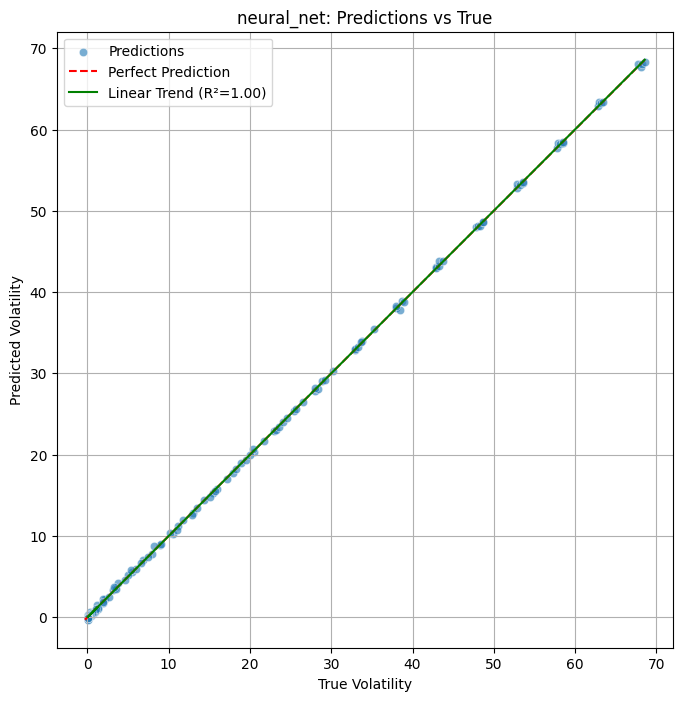

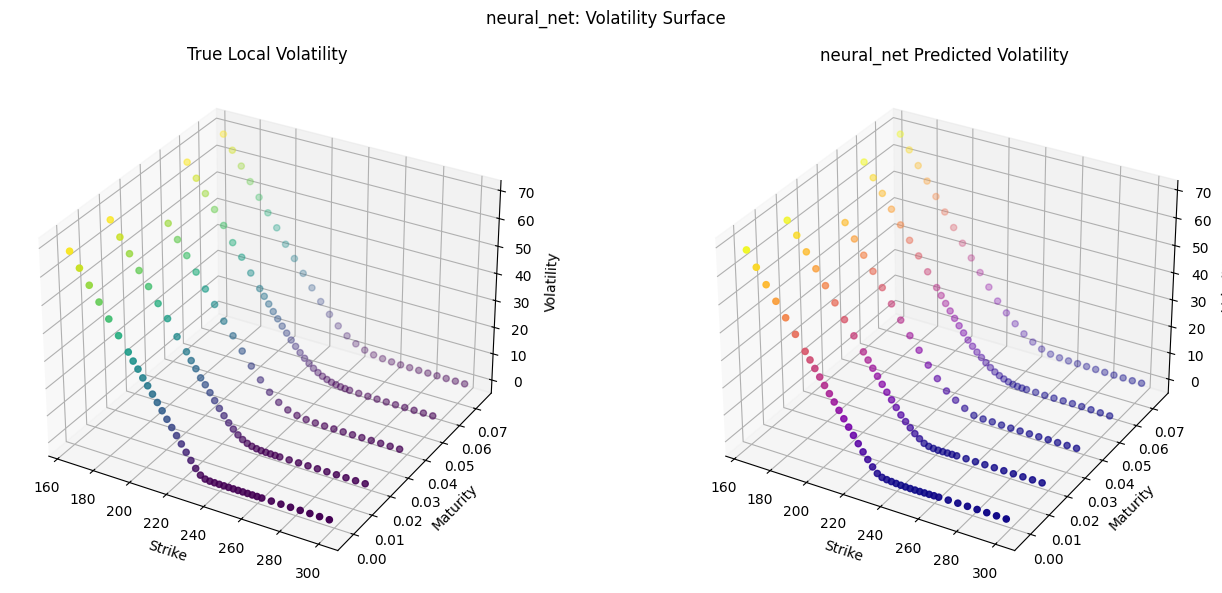

Evaluating Model: gaussian_process
Metrics: {'MSE': 0.005732895913592337, 'RMSE': np.float64(0.07571588943935306), 'MAE': 0.04011429520913591, 'R2': 0.9999863728757646}


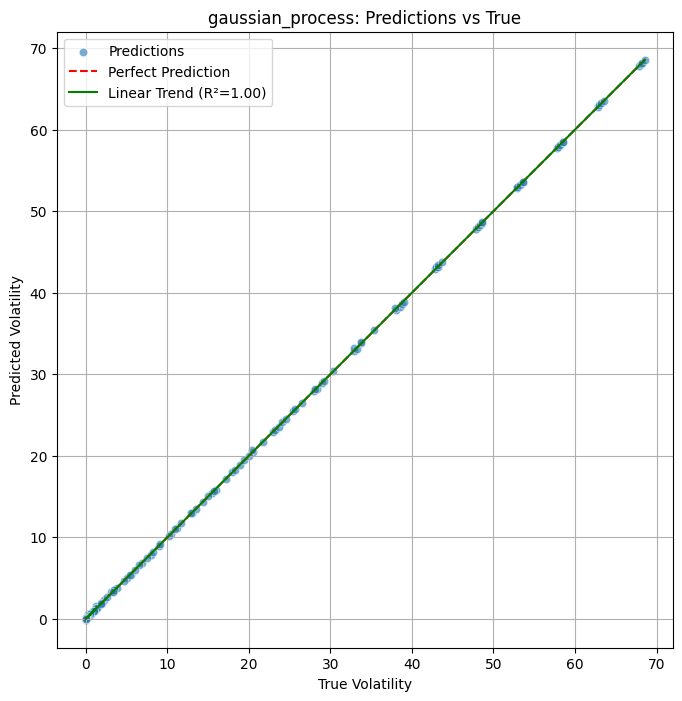

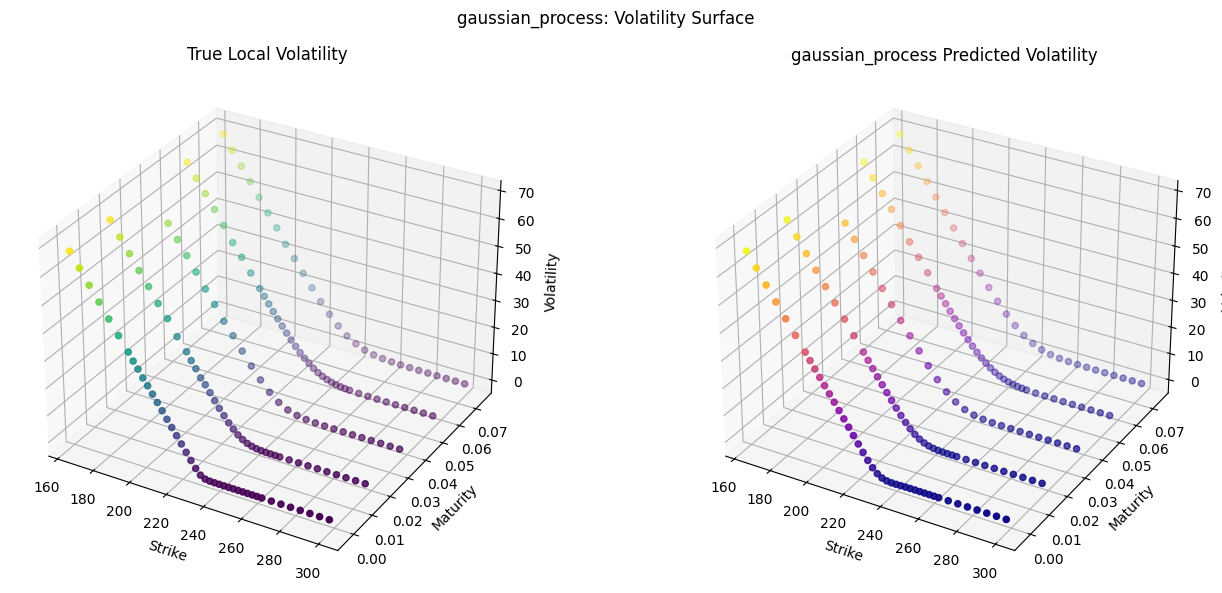

Evaluating Model: reinforcement_learning
Metrics: {'MSE': 662.498981277898, 'RMSE': np.float64(25.739055563052386), 'MAE': 15.90751669633208, 'R2': -0.5747636202976303}


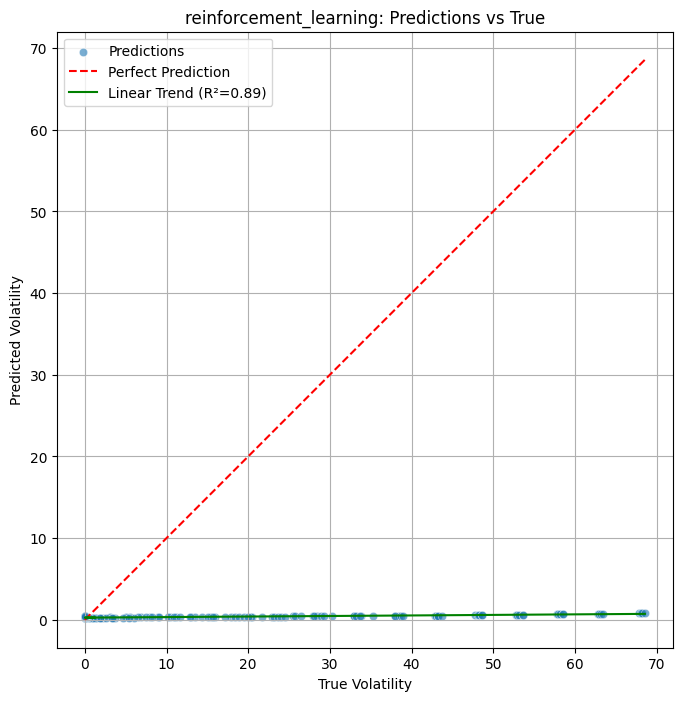

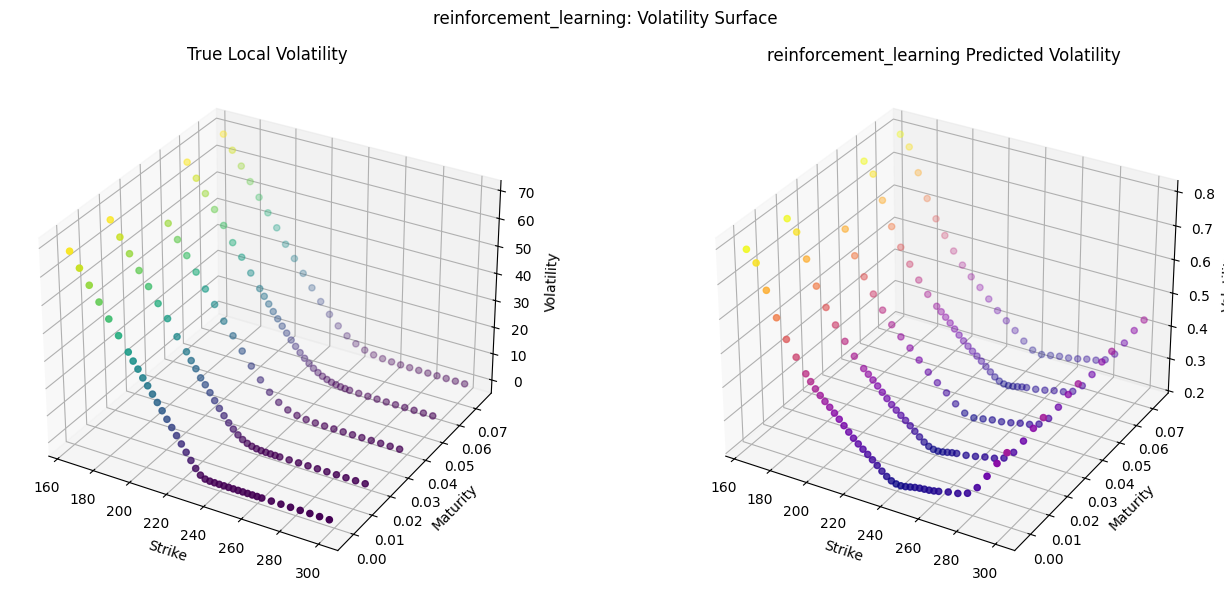


Model Comparison Table:
                               MSE       RMSE        MAE        R2
neural_net                0.031202   0.176642   0.129532  0.999926
gaussian_process          0.005733   0.075716   0.040114  0.999986
reinforcement_learning  662.498981  25.739056  15.907517 -0.574764


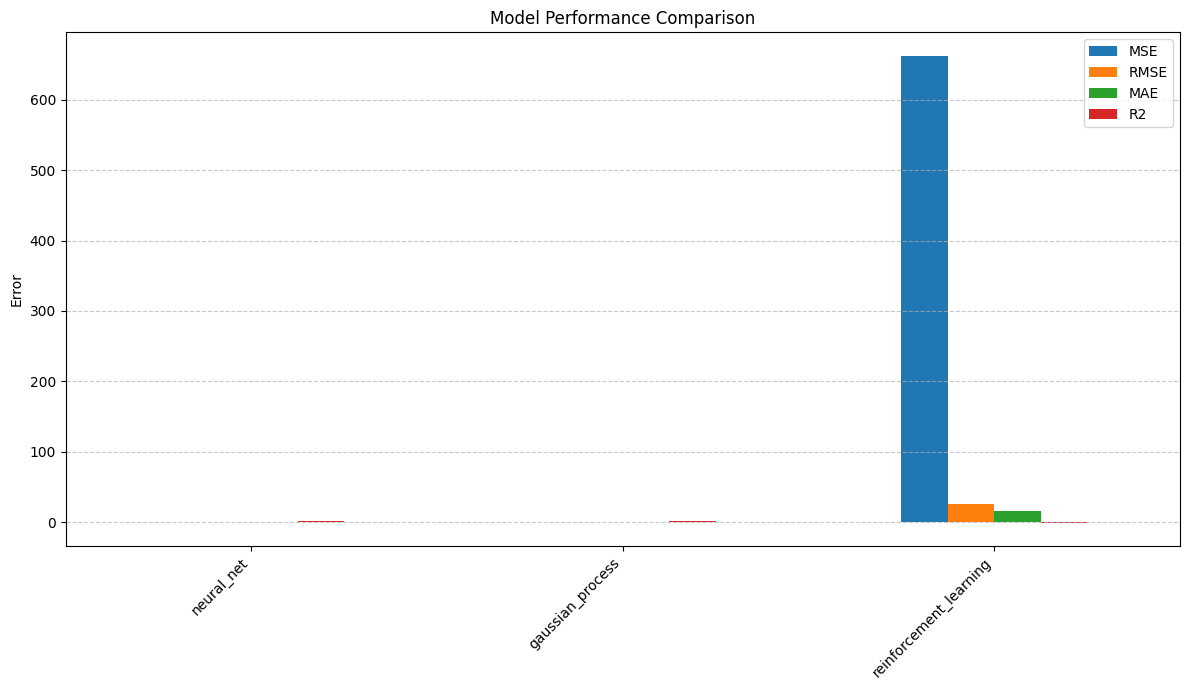


📊 Evaluator and Visualization for GOOG
Evaluating Model: neural_net
Metrics: {'MSE': 0.039024786358262877, 'RMSE': np.float64(0.19754692191543474), 'MAE': 0.15072166014628835, 'R2': 0.9998889869601149}


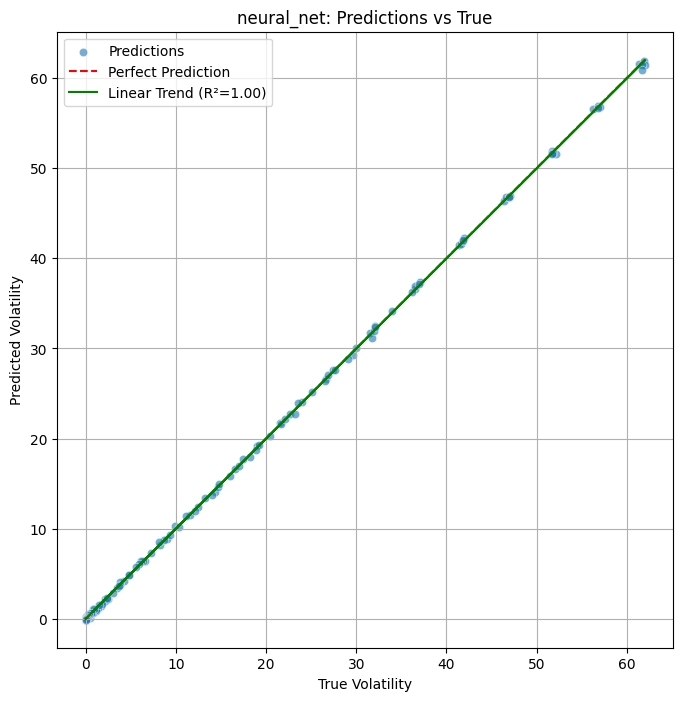

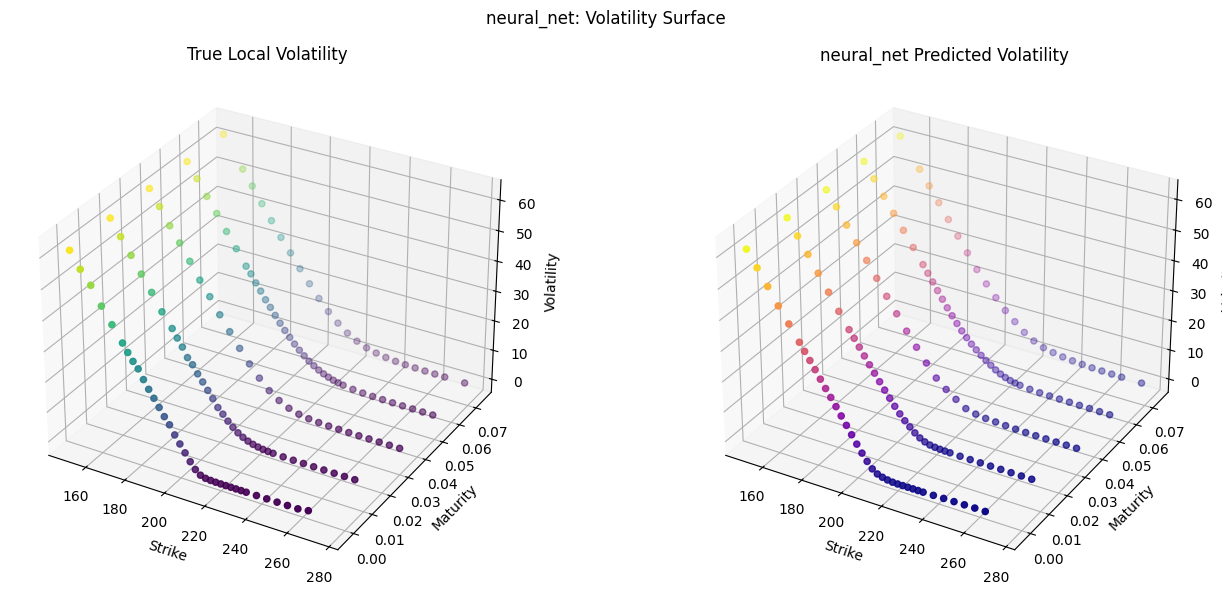

Evaluating Model: gaussian_process
Metrics: {'MSE': 0.007905721080197596, 'RMSE': np.float64(0.08891412193908005), 'MAE': 0.04937012989264005, 'R2': 0.9999775107512047}


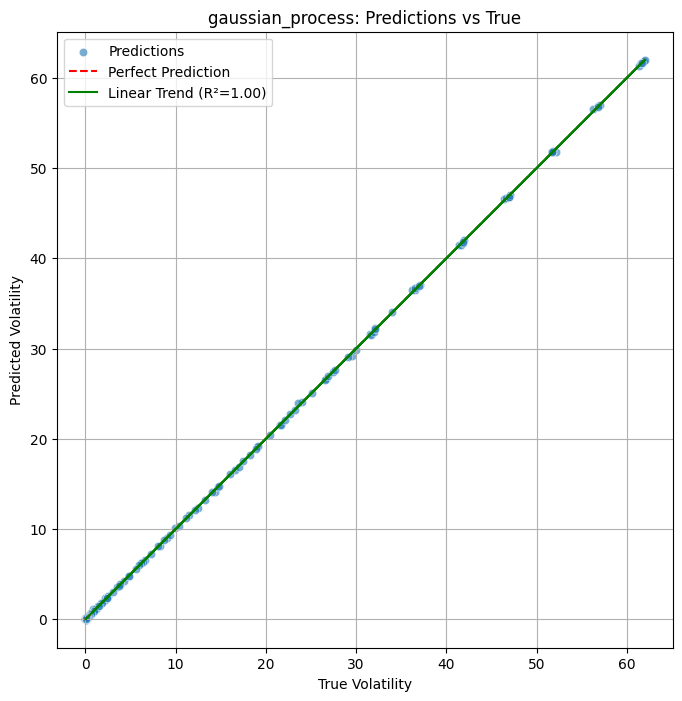

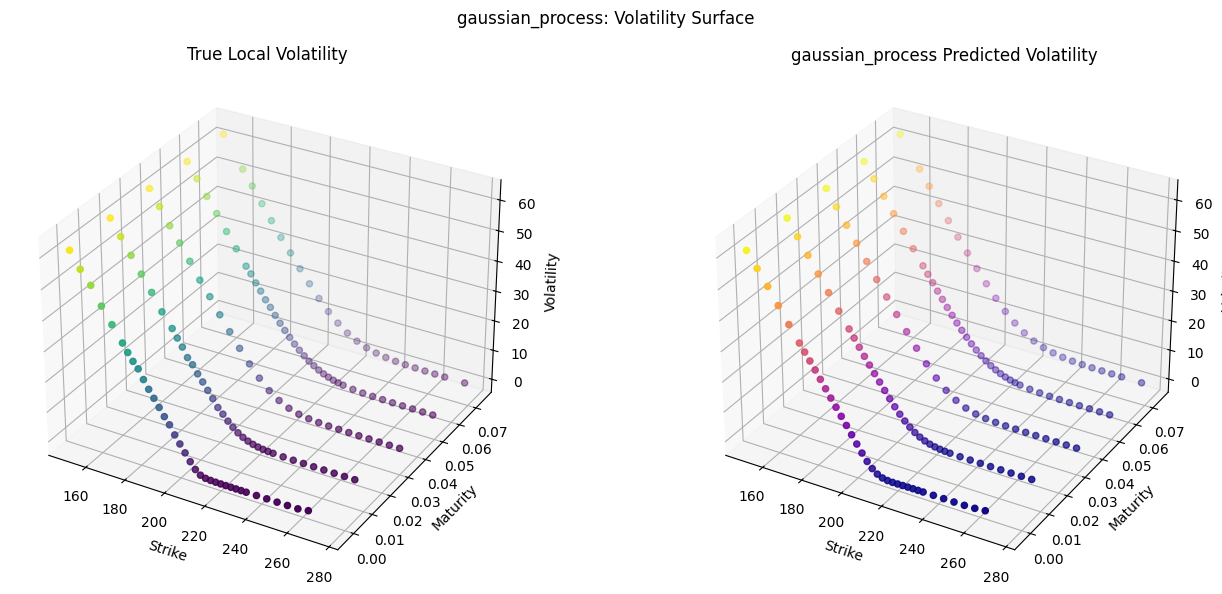

Evaluating Model: reinforcement_learning
Metrics: {'MSE': 586.9117970639143, 'RMSE': np.float64(24.226262548398054), 'MAE': 15.523222441248832, 'R2': -0.6695764107047422}


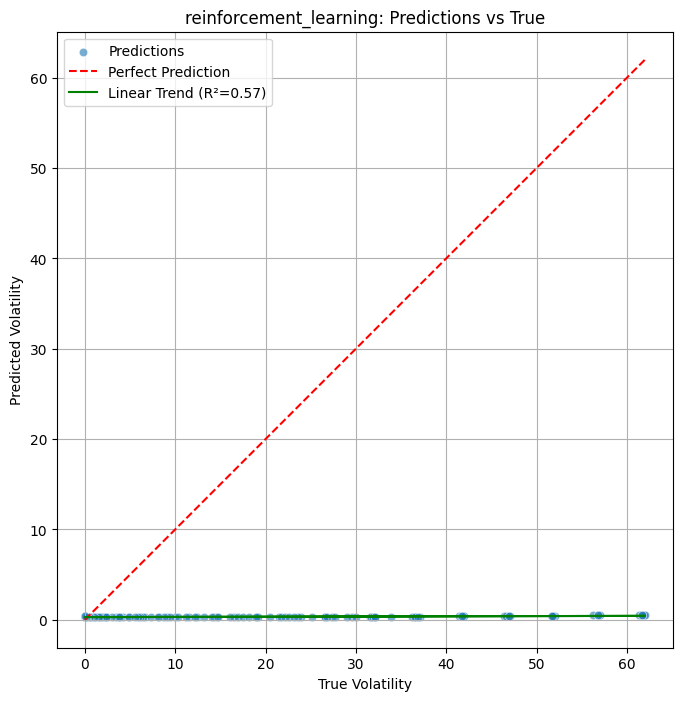

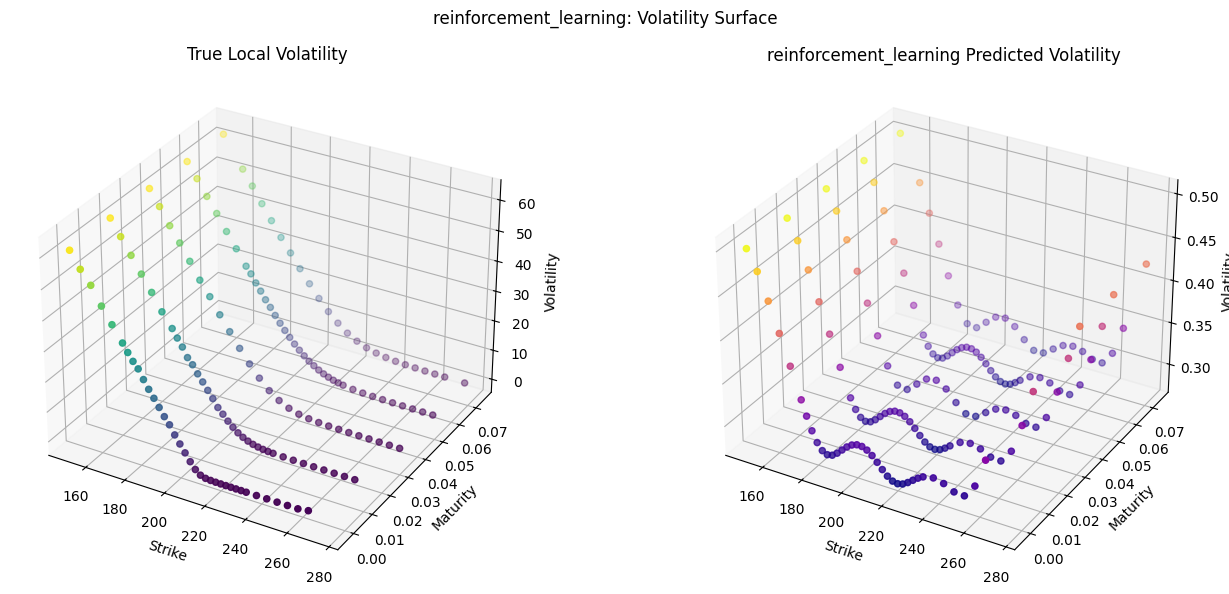


Model Comparison Table:
                               MSE       RMSE        MAE        R2
neural_net                0.039025   0.197547   0.150722  0.999889
gaussian_process          0.007906   0.088914   0.049370  0.999978
reinforcement_learning  586.911797  24.226263  15.523222 -0.669576


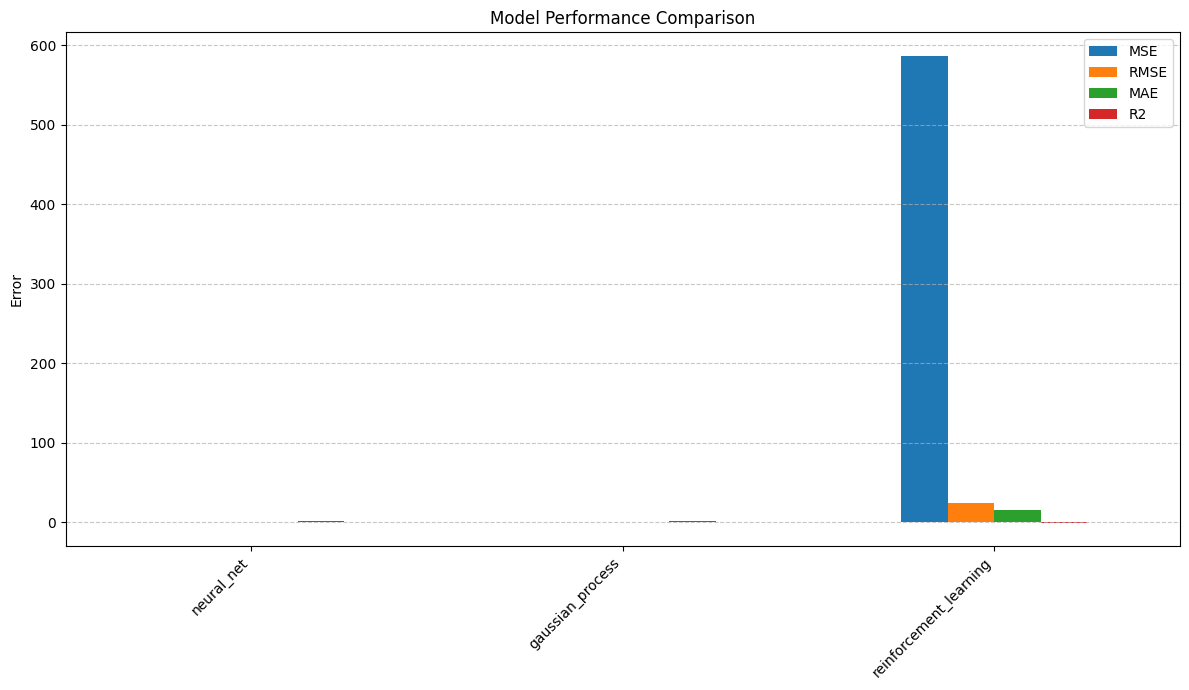


📊 Evaluator and Visualization for MSFT
Evaluating Model: neural_net
Metrics: {'MSE': 0.08402356208620575, 'RMSE': np.float64(0.2898681805341969), 'MAE': 0.22180338438987712, 'R2': 0.9999276457503498}


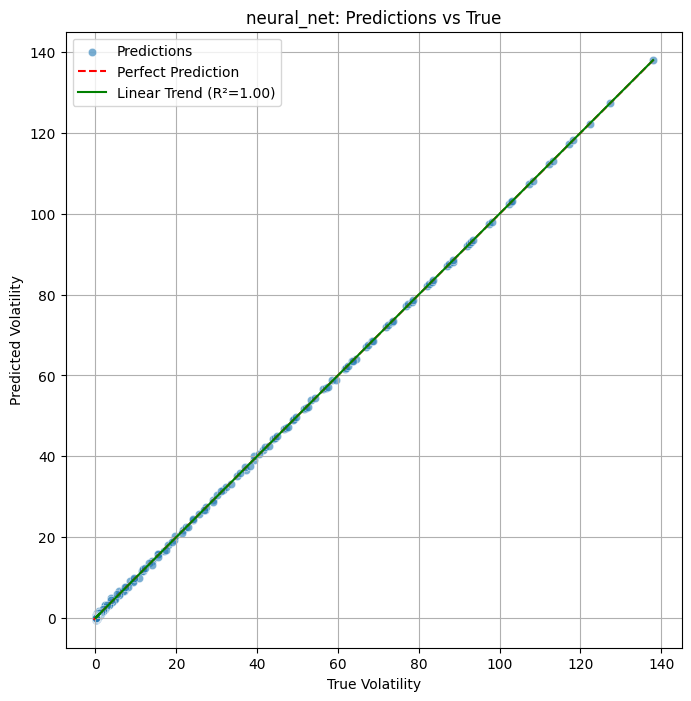

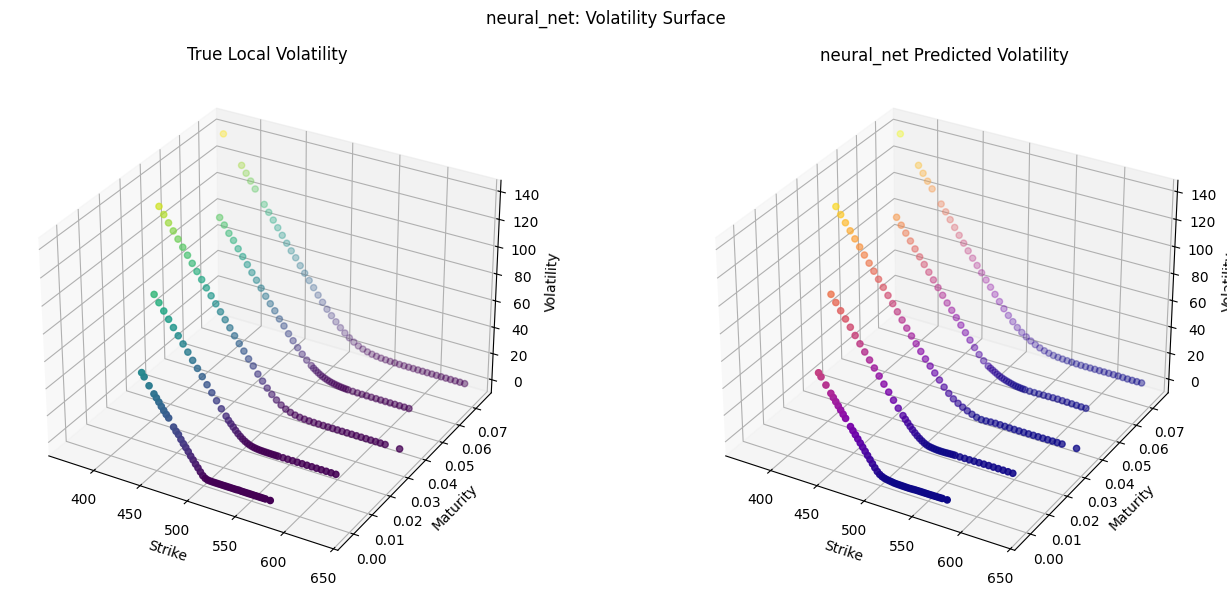

Evaluating Model: gaussian_process
Metrics: {'MSE': 0.010619041419408518, 'RMSE': np.float64(0.10304873322563707), 'MAE': 0.052651119962134285, 'R2': 0.9999908557462356}


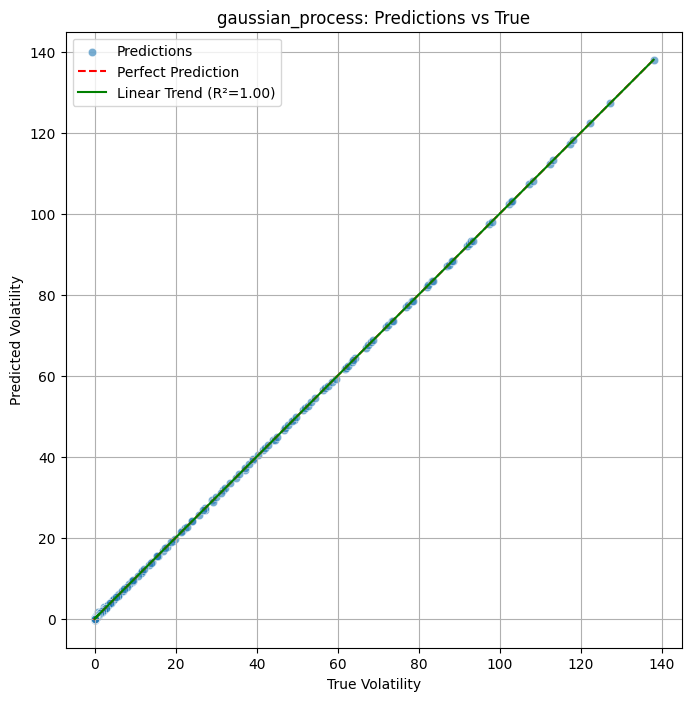

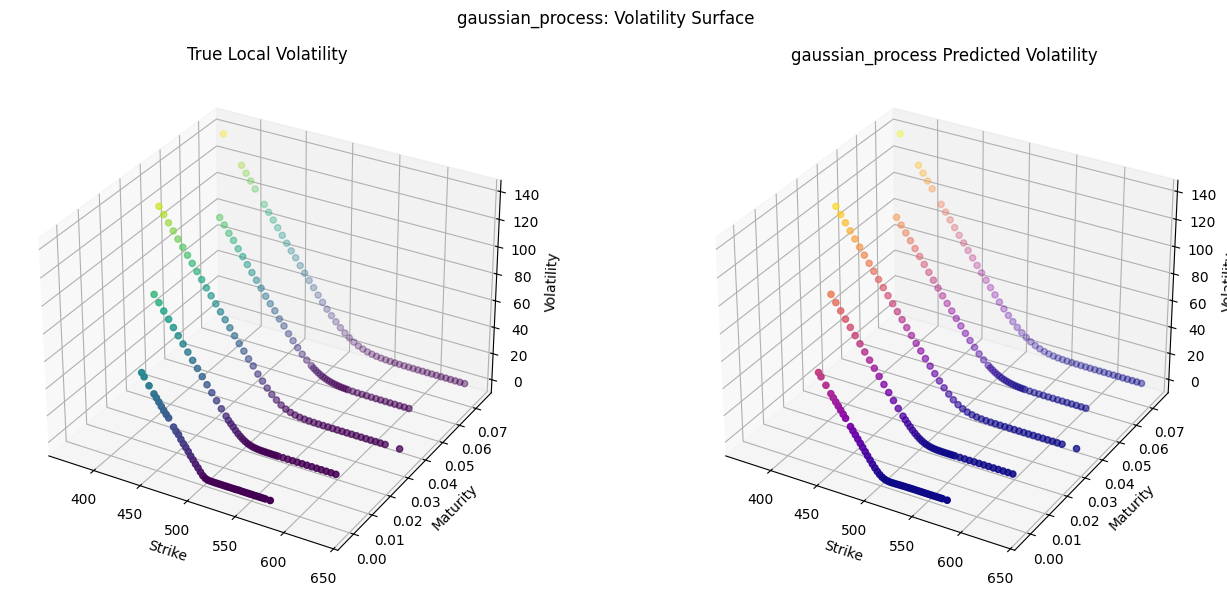

Evaluating Model: reinforcement_learning
Metrics: {'MSE': 1758.1888272197134, 'RMSE': np.float64(41.93076230191521), 'MAE': 24.56451167943071, 'R2': -0.5140090491098144}


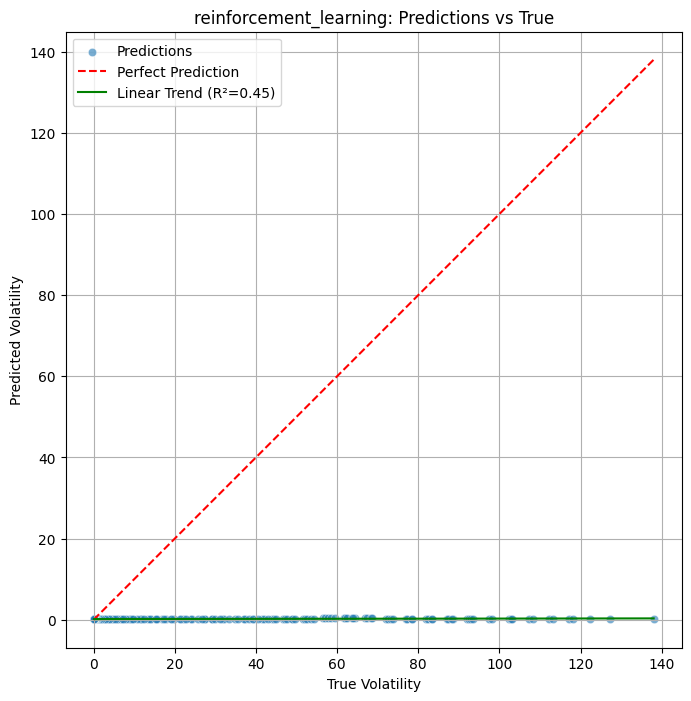

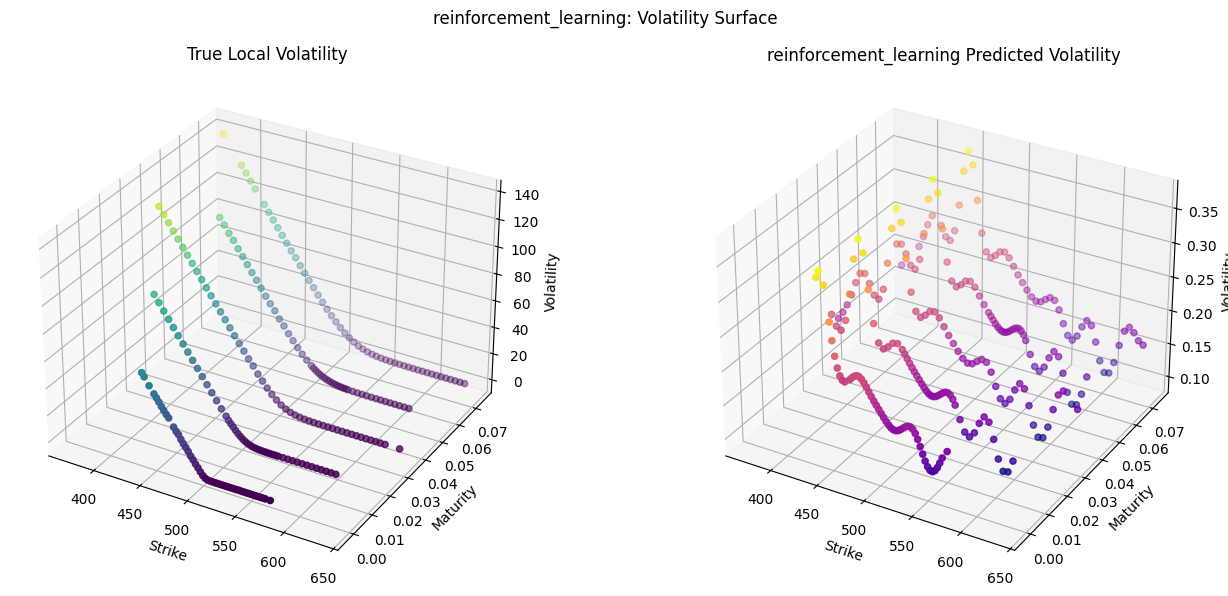


Model Comparison Table:
                                MSE       RMSE        MAE        R2
neural_net                 0.084024   0.289868   0.221803  0.999928
gaussian_process           0.010619   0.103049   0.052651  0.999991
reinforcement_learning  1758.188827  41.930762  24.564512 -0.514009


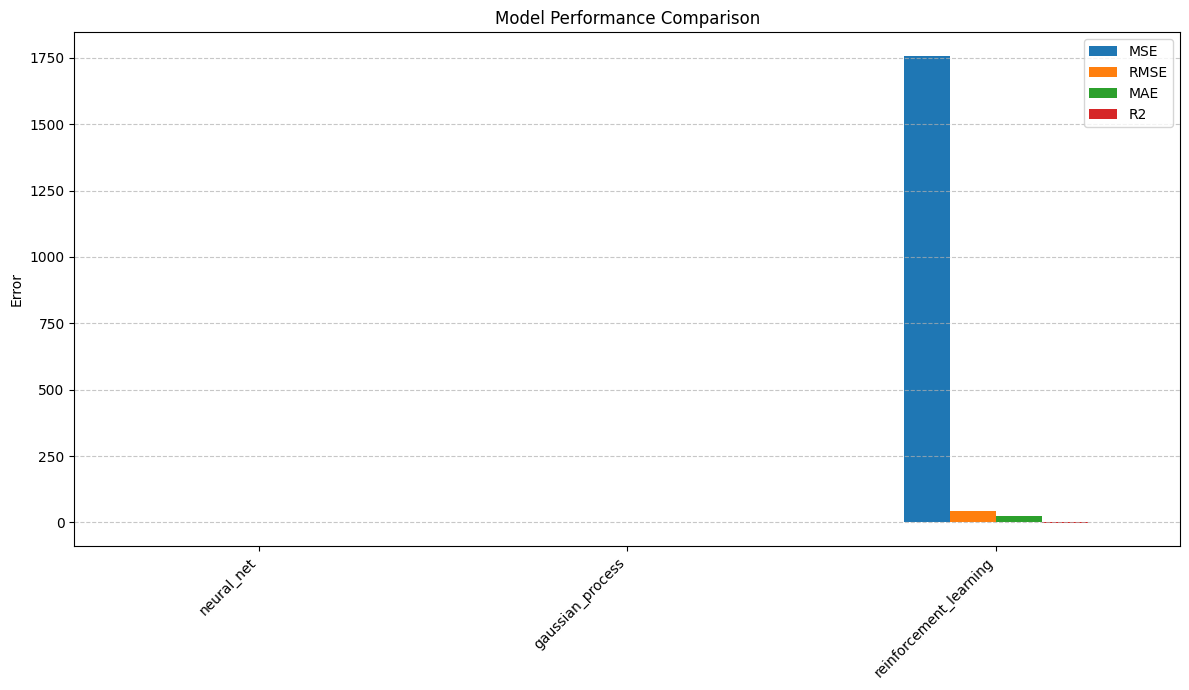


📊 Evaluator and Visualization for AMZN
Evaluating Model: neural_net
Metrics: {'MSE': 0.0316949572687578, 'RMSE': np.float64(0.1780307761842255), 'MAE': 0.13580808479405004, 'R2': 0.999918982398139}


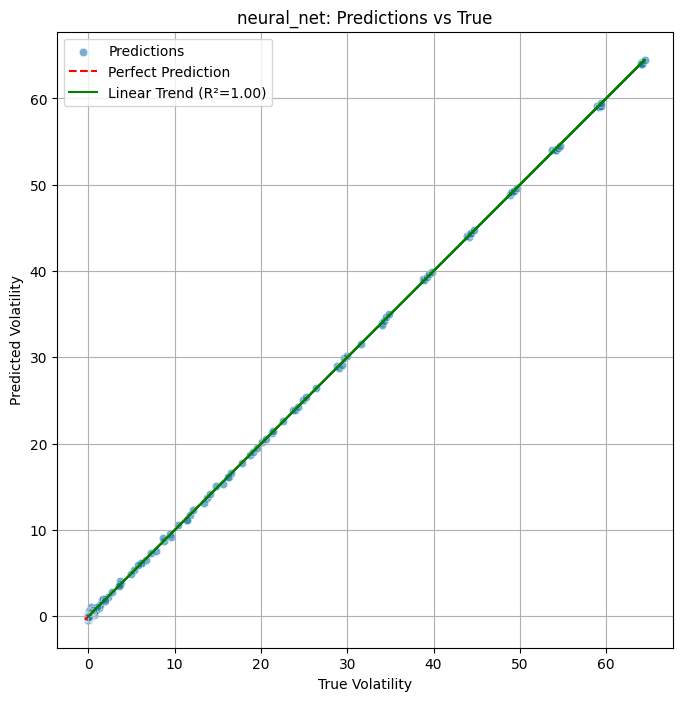

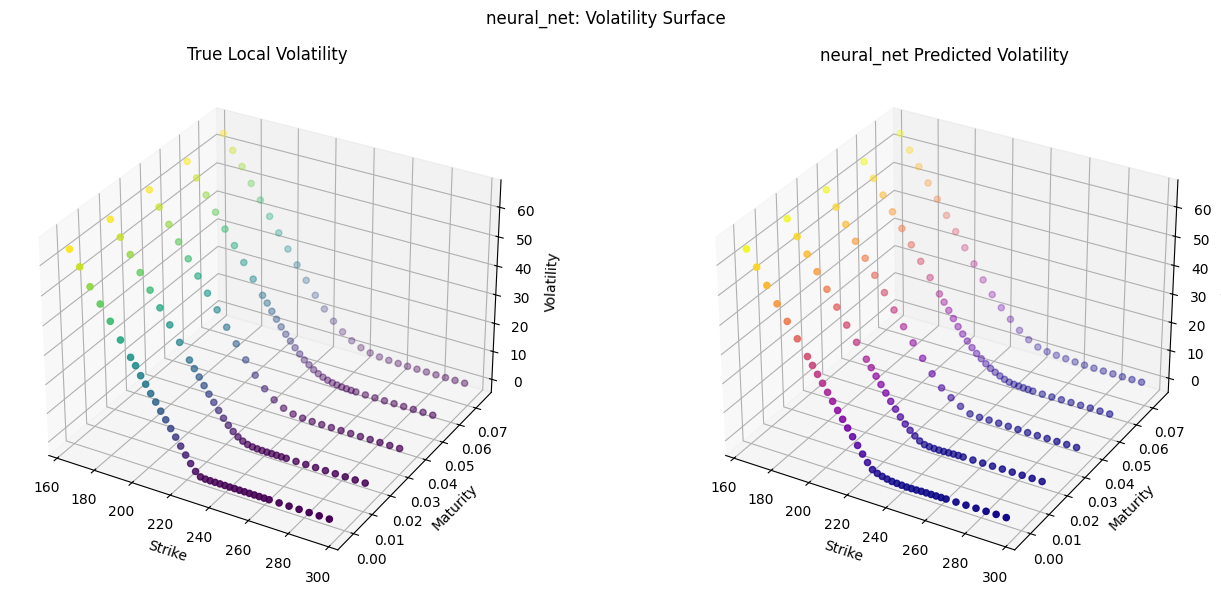

Evaluating Model: gaussian_process
Metrics: {'MSE': 0.0038008453027099758, 'RMSE': np.float64(0.061650995958783796), 'MAE': 0.03097030580826078, 'R2': 0.999990284404902}


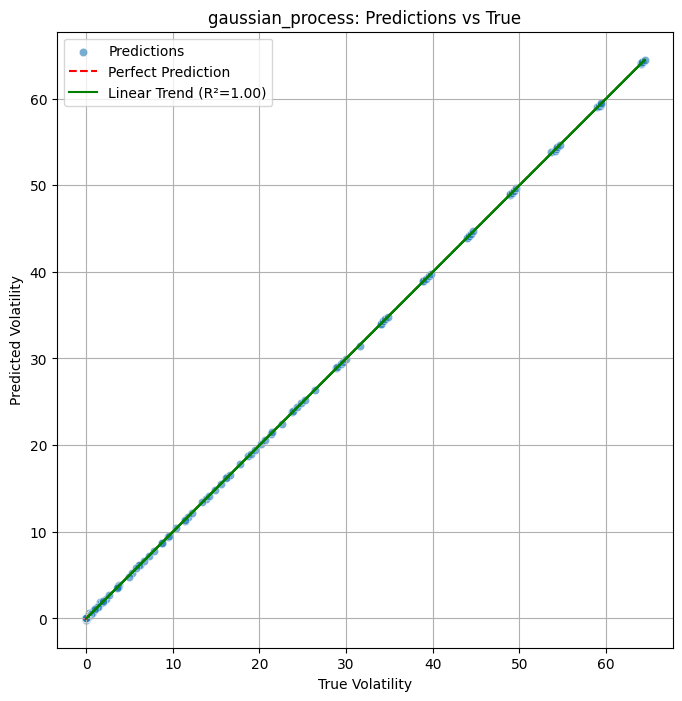

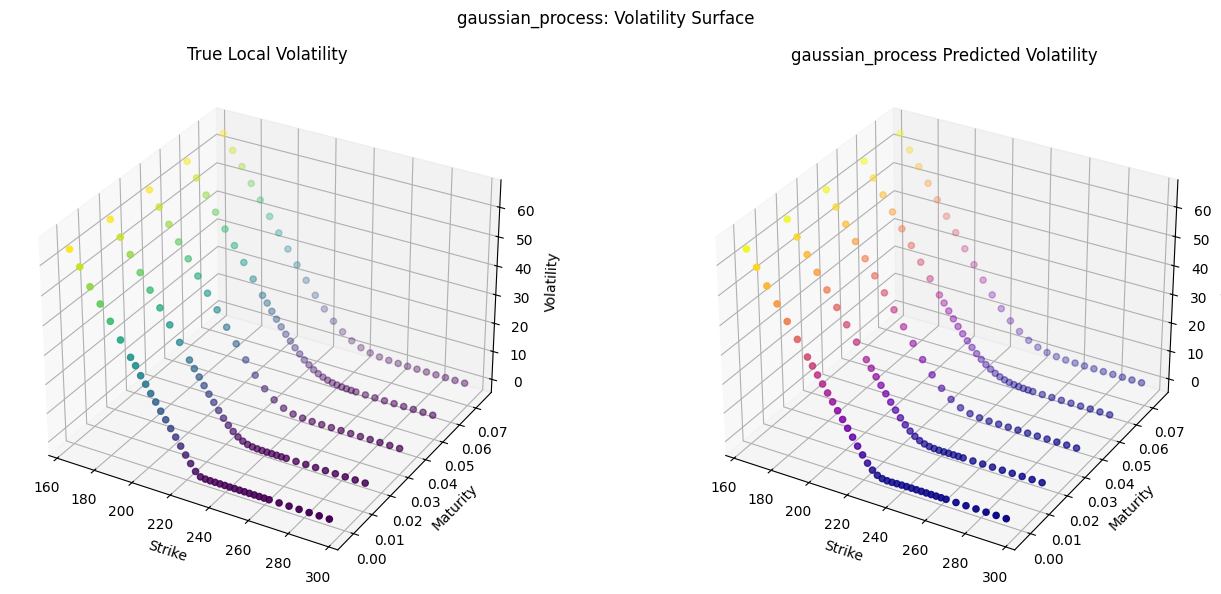

Evaluating Model: reinforcement_learning
Metrics: {'MSE': 602.0977094436336, 'RMSE': np.float64(24.537679381792273), 'MAE': 14.858346648513953, 'R2': -0.5390622581213351}


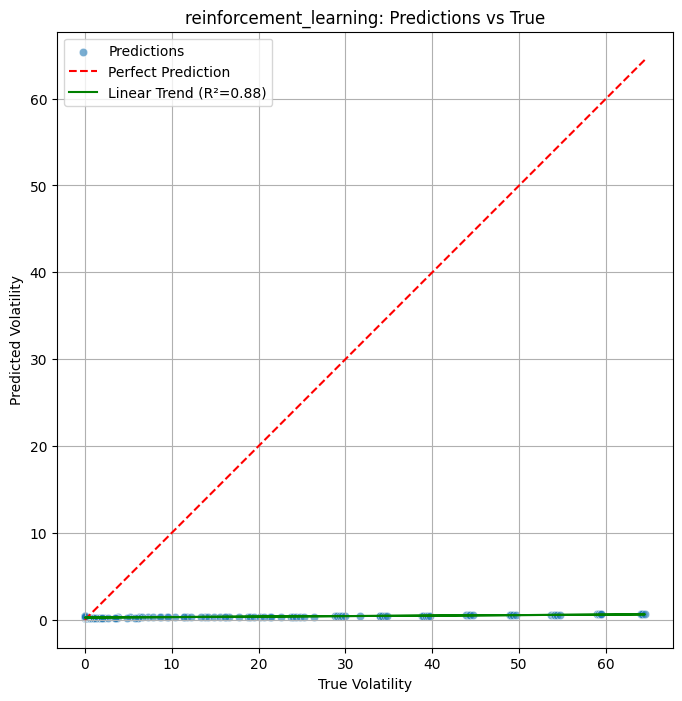

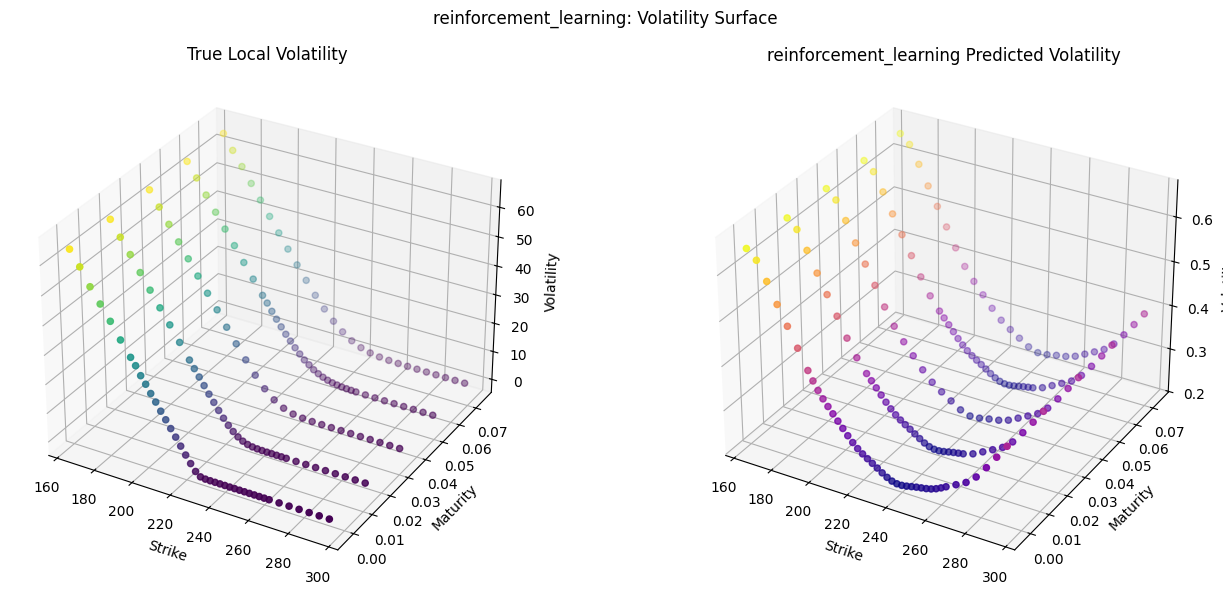


Model Comparison Table:
                               MSE       RMSE        MAE        R2
neural_net                0.031695   0.178031   0.135808  0.999919
gaussian_process          0.003801   0.061651   0.030970  0.999990
reinforcement_learning  602.097709  24.537679  14.858347 -0.539062


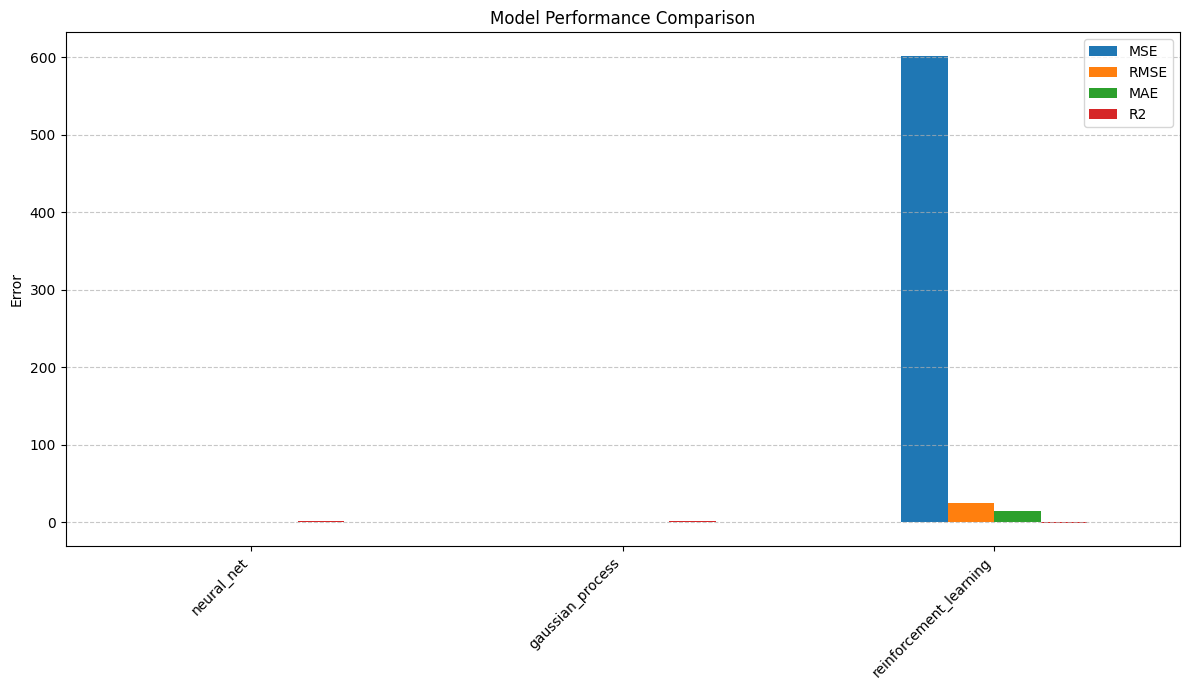

In [27]:
for key in calibrators:
    df = market_data[key]["data"]
    X = df[["Strike", "Maturity"]].values
    y = df["OptionPrice"].values

    # Remove rows with NaNs in X or y
    mask = ~np.isnan(X).any(axis=1) & ~np.isnan(y)
    X_clean = X[mask]
    y_clean = y[mask]

    if X_clean.shape[0] == 0:
        print(f"\n⚠️ Skipping {key.upper()} — no valid data after NaN removal.")
        continue

    print("\n" + "="*60)
    print(f"📊 Evaluator and Visualization for {key.upper()}")

    # Initialize evaluator
    evaluator = CalibrationEvaluator(calibrators[key], df)

    # Loop over models
    for model_name in calibrators[key].keys():
        print("="*60)
        print(f"Evaluating Model: {model_name}")

        # Metrics
        metrics, preds = evaluator.evaluate(X_clean, y_clean, model_name)
        print("Metrics:", metrics)

        # Prediction Scatter
        evaluator.plot_predictions(X_clean, y_clean, model_name)

        # Volatility Surface
        evaluator.plot_surface(X_clean, y_clean, model_name)

    # Compare models side by side
    comparison_df = evaluator.compare_models(X_clean, y_clean)
    print("\nModel Comparison Table:")
    print(comparison_df)

    # Comparison bar chart
    evaluator.plot_model_comparison()

